# Othello Move Predictor

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import random
import fastai
import numpy as np
from progress.bar import IncrementalBar
from pathlib import Path
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.callbacks.mem import PeakMemMetric
from Othello_CNN import OthelloCNN
from torchsummary import summary

## Convert NumPy matrices to PNG

In [43]:
data_path = Path( '/users/ugrad/pretoriw/Documents/5th_Year/AI/numpy_boards_moves' )
data_save_path = Path( '/users/ugrad/pretoriw/Documents/5th_Year/AI/png_boards_moves_3_chan' )
fnames = os.listdir('/users/ugrad/pretoriw/Documents/5th_Year/AI/numpy_boards_moves')
empty_mat = np.zeros( (8,8) )

bar = IncrementalBar('Processing', max = len(fnames))
for name in fnames:
    mat_2 = np.load( data_path / name)
    mat_3 = np.dstack((mat_2, empty_mat))
    mat_png = PIL.Image.fromarray( (mat_3 * 255).astype(np.uint8))
    
    save_path = data_save_path / (name[:-3] + 'png')
    mat_png.save(save_path)
    bar.next()
    
bar.finish()

### Re-define how we want open_image to perform

In [44]:
def open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
        after_open:Callable=None)->Image:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(fn).convert(convert_mode)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(x)

fastai.vision.Image.open_image = open_image

### Load data

(60, None)

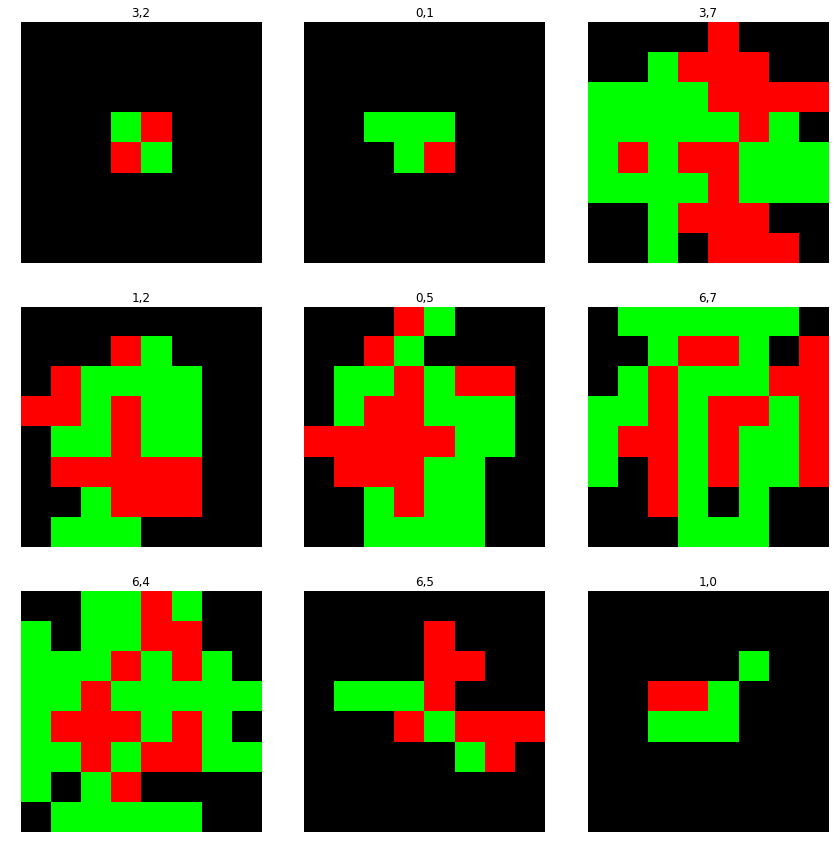

In [58]:
# Batch size
bs = 256

# Define path to images
data_path = Path( '/users/ugrad/pretoriw/Documents/5th_Year/AI/png_boards_moves_3_chan' )

# Get a list of names of all images in folder
fnames = get_image_files( data_path )

# Define function to retrieve label from filename
def get_labels(file_path):
    file_name = file_path.name   # Get the file name (not path)
    label = file_name[:1] + ',' + file_name[1:2]        # Get the first two chars of name
    return label

# Load data into Databunch
data = ImageDataBunch.from_name_func( data_path, fnames, label_func=get_labels, bs=bs)

data.c, data.show_batch( rows = 3 )

((Image (3, 8, 8), Category 1,7), None)

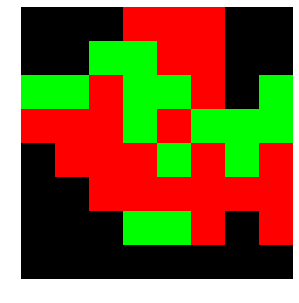

In [61]:
data.train_ds[0], data.train_ds[0][0].show( figsize=(5,5))

### Build learner and plot learning rate

In [ ]:
# Load model onto GPU..?
device = torch.device('cuda')
model = OthelloCNN().to(device)

# Create a learner
learn = cnn_learner( data, model, metrics = error_rate )

# Find the optimal learning rate
lr_find( learn )
learn.recorder.plot()

### Run training

In [ ]:
lr = 1e-3

learn.fit_one_cycle( 4, lr )

learn.save( 'stage1' )
learn.load( 'stage1' )

### Other Cells...

In [ ]:
# # Batch size
# bs = 256

# # Define path to images
# data_path = Path( '/users/ugrad/pretoriw/Documents/5th_Year/AI/numpy_boards_moves' )

# # Get a list of names of all images in folder
# # fnames = get_image_files( data_path )
# fnames = os.listdir('/users/ugrad/pretoriw/Documents/5th_Year/AI/numpy_boards_moves')
# split_idx = int(0.15 * len(fnames))

# random.shuffle(fnames)
# fnames_train = fnames[:split_idx]
# fnames_val = fnames[split_idx:]

# # Define function to retrieve label from filename
# def get_label(file_path):
#     file_name = file_path.name   # Get the file name (not path)
#     label = file_name[:2]        # Get the first two chars of name

# class NumpyDataset(Dataset):
#     def __init__(self, data_path, fnames ):
#         self.path = data_path
#         self.names = fnames
        
#     def __len__(self):
#         return len(self.names)
    
#     def __getitem__(self, idx):
#         file_path = self.path/self.names[idx]
        
#         img = np.load( file_path )
#         img = np.float32(img)
#         img = Image(img)
# #         img = torch.Tensor( img )
        
#         label = get_label( file_path )
        
#         return img, label
    
# train_dataset = NumpyDataset( data_path, fnames_train )
# val_dataset = NumpyDataset(data_path, fnames_val)

# train_dataloader = DataLoader( train_dataset, batch_size = bs)
# val_dataloader = DataLoader( val_dataset, batch_size = bs)

# data = ImageDataBunch(train_dataloader, val_dataloader)
# data.c = 60